## Perform Lung Segmentation
Instructions
1. Execute segmentation exclusively for the lungs
2. The masks are available for the left lung (labelled 3), right lung (labelled 4), and trachea(labelled 5)
3. Eliminate the trachea label, amalgamate the left and right masks into a single label, and conduct segmentation for the entire lung.


### Step 1 : Import Python Modules and understand the files

In [ ]:
import os # For System operations
import glob # To read files from a folder
import gzip # To unzip contents
import shutil # To perform file operations
import random as rd # To generate random numbers
import nibabel as nib # To load .nii.gz files
import cv2 # for image operations
import vedo # to view the 3d image 
import matplotlib.pyplot as plt # To plot the images
import numpy as np # Numpy operations

In [ ]:
def extract_gz(folder_path, save_path): # initially did to check the file contents
    """
    Converts the .nii.gz files in the folder_path to .nii files and saves them in the save_path
    basically to decompress the files
    """
    files = os.listdir(folder_path)
    for f in files:
        with gzip.open(f"{folder_path}/{f}", "rb") as asd:
            with open(f"{save_path}/{f[:-3]}", "wb") as sdf:
                shutil.copyfileobj(asd, sdf)
                
extract_gz("Dataset/imagesTr", "Dataset/Images") # extract all the images "*.nii.gz" to "*.nii" files
extract_gz("Dataset/labelsTr", "Dataset/Labels") # extract all the masks "*.nii.gz" to "*.nii" files

### Step 2: Visualize and Analyze the data

In [3]:
image_list = os.listdir("./Dataset/imagesTr") # load the images
label_list = os.listdir("./Dataset/labelsTr") # Load the label masks
print(f"3D CT scans of Lungs : {len(image_list) }\n3D Masks : {len(label_list)}")

3D CT scans of Lungs : 45
3D Masks : 45


In [4]:
# Check size of the 3d scans
rannum = rd.randint(0, len(image_list)) # random number to select a random image
test_image = nib.load(f"./Dataset/imagesTr/{image_list[rannum]}").get_fdata() # load the random 3d image
test_label = nib.load(f"./Dataset/labelsTr/{label_list[rannum]}").get_fdata() # load the random 3d mask
print(test_image.shape, test_label.shape)

(512, 512, 538) (512, 512, 538)


In [5]:
def display(real, mask):
    """
    This function displays the images, of a real image and its corresponding mask
    """
    # View the images
    zlen, ylen, xlen = real.shape
    z_slice, y_slice, x_slice = zlen//2, ylen//2, xlen//2 # get the middle slice of the image
    # print(z_slice, y_slice, x_slice)
    # Creating a functionality to view the images
    fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 12))


    axes[0, 0].imshow(np.rot90(real[:, :, x_slice]))
    axes[0, 1].imshow(np.rot90(real[:, y_slice, :]))
    axes[0, 2].imshow(np.rot90(real[z_slice, :, :]))
    axes[0, 0].set_title("Axial Slice")
    axes[0, 0].set_ylabel("CT Scan - Original", fontsize = 12)

    axes[1, 0].imshow(np.rot90(real[:, :, x_slice]), cmap = "gray")
    axes[1, 1].imshow(np.rot90(real[:, y_slice, :]), cmap = "gray")
    axes[1, 2].imshow(np.rot90(real[z_slice, :, :]), cmap = "gray")
    axes[0, 1].set_title("Coronal Slice")
    axes[1, 0].set_ylabel("CT Scan - Grayscaled", fontsize = 12)


    axes[2, 0].imshow(np.rot90(mask[:, :, x_slice]))
    axes[2, 1].imshow(np.rot90(mask[:, y_slice, :]))
    axes[2, 2].imshow(np.rot90(mask[z_slice, :, :]))
    axes[0, 2].set_title("Sagittal Slice")
    axes[2, 0].set_ylabel("Segmented Mask", fontsize = 12)


    # (512, 512, 149) <=> (top view from the head, front view of the body, side view of the body) <=> (axial slice, coronal slice, sagittal slice)

    plt.show()


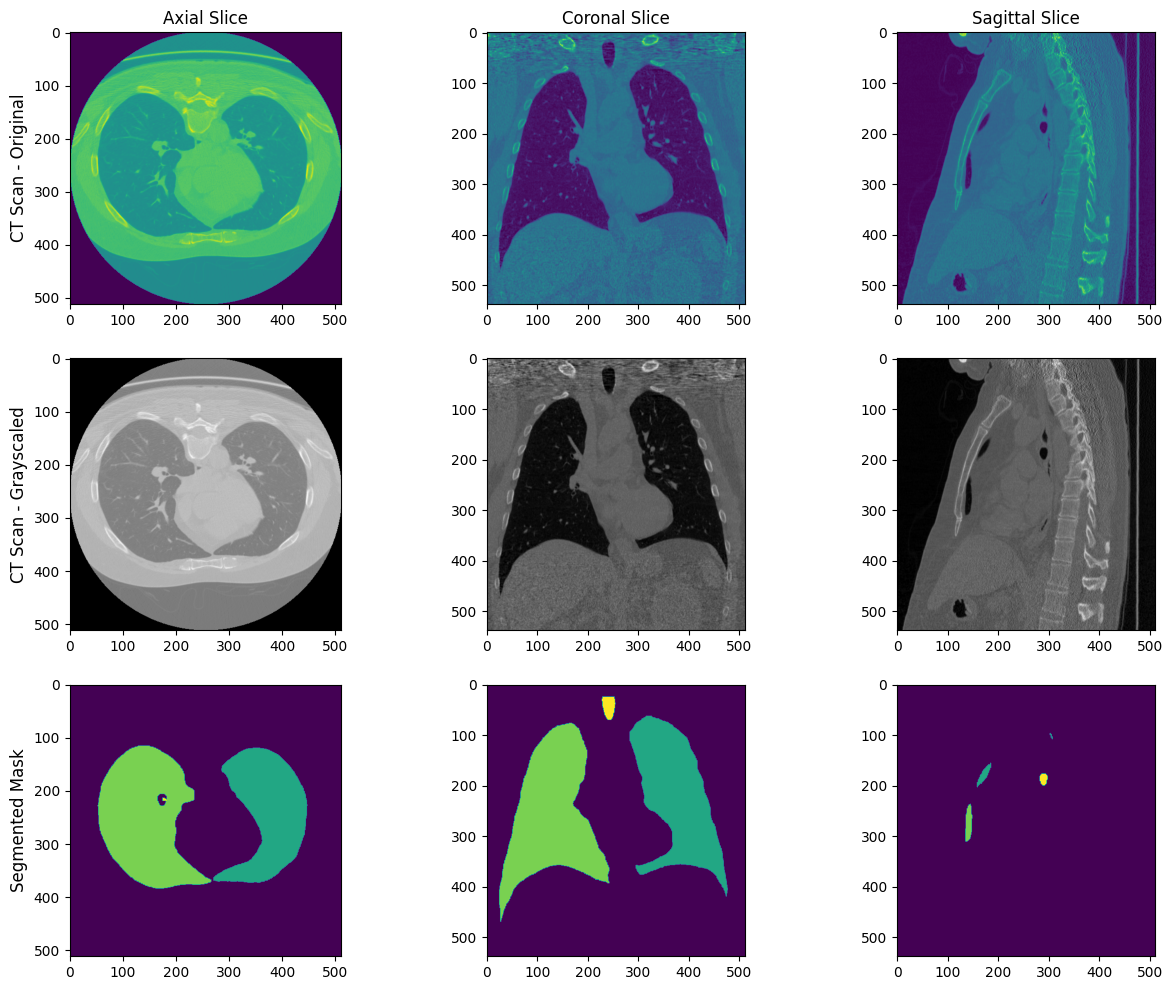

In [6]:
display(test_image, test_label)

##### Conclusion:
- From the dataset, it contains 45 images of CT scans of lungs and also their corresponding masks.
- The mask dataset contains the segmented potion/region of the lungs and the trachea
- The masks are available for the left lung (labelled 3), right lung (labelled 4), and trachea(labelled 5)
- The image dimensions are set to (512 * 512 * z), where z varies along the depth (i.e from chin to the bottom of the lungs)
- From the above image, for sample, Axial, Coronal, and Sagittal views of the lungs are shown

### Step 3: Excluding/Cropping out Trachea from the Mask

- From the above image, at the Segmented Mask row of a particular patient, we can see that is is segmented/distinguished into 3 colored parts

| Portion | Colour | Label |
|--|--|--|
| Left Lung | Lime Green | 3 |
| Right Lung | Dark Green | 4 |
| Trachea | Yellow | 5 |

- Task is to remove Trachea from the 3D Mask image.
- Task is to amalgamate/merge the label for left and right lung as one.


In [ ]:
# Removing all trachea labels and merging the labels for lung

for every in label_list: # For every 3D mask
    img = nib.load(f"./Dataset/labelsTr/{every}") # Load the mask
    croppedimg = img.get_fdata()
    croppedimg[croppedimg == 5.0] = 0.0 # Remove the trachea label by assigning it to 0
    croppedimg[(croppedimg == 3.0) | (croppedimg == 4.0)] = 1.0 # Merge right and left lung label to 1
    modified = nib.Nifti1Image(croppedimg, img.affine) # Save the modified masked image
    nib.save(modified, f"./Dataset/Modified/{every}")

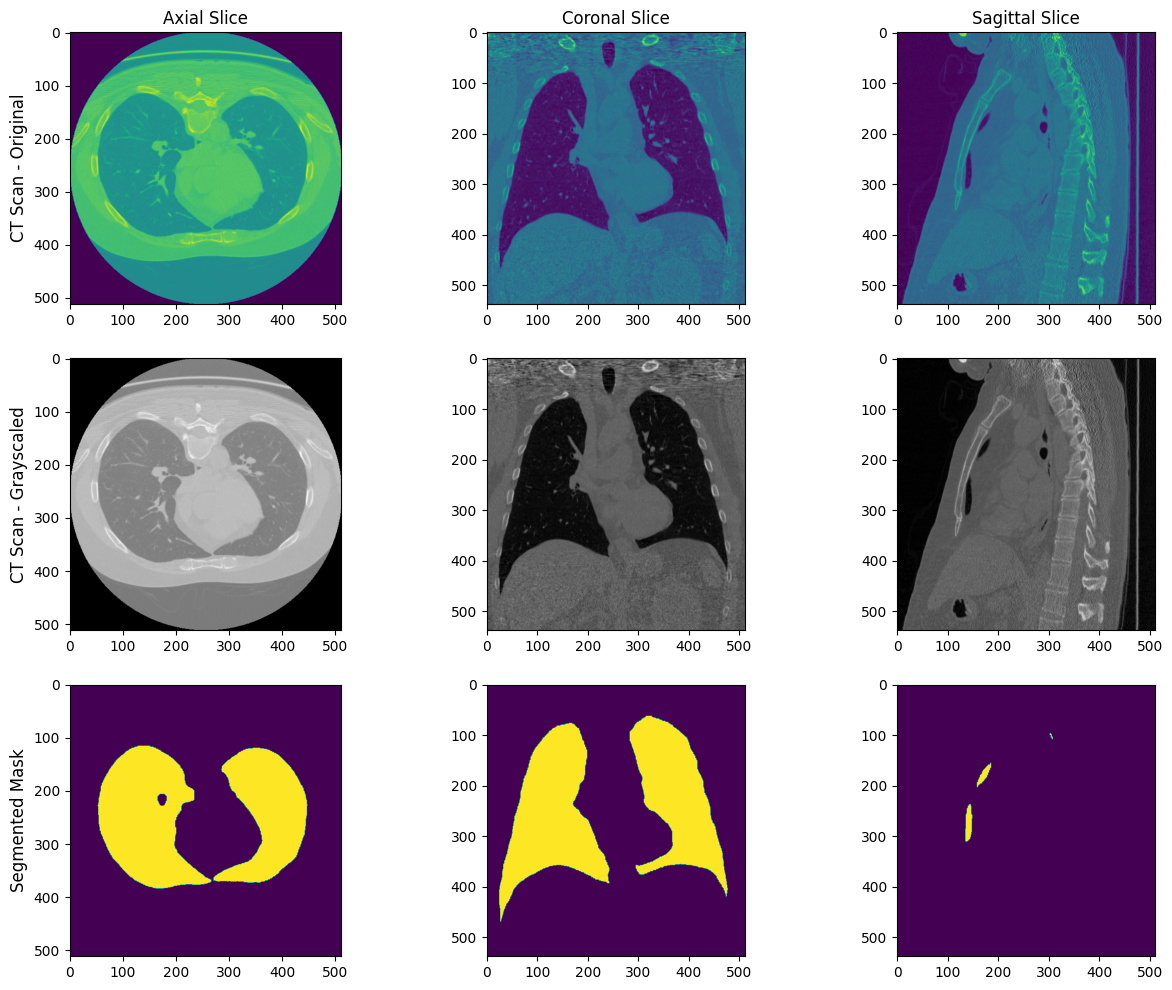

In [7]:
modified_list = os.listdir("./Dataset/Modified") # Load the label masks
test_modified = nib.load(f"./Dataset/Modified/{modified_list[rannum]}").get_fdata() # load the image

display(test_image, test_modified)

##### Conclusion
- Removed trachea label from the mask as shown one of the slice of the masked image as in the above
- Merged the image of left and right lung as one as shown in the above image

### Step 4: Preparing Dataset for Training

Now, training can be done in three ways:
|Slno| Methods |Disadvantages|
|--|--|--|
| 1 |Training ML model by feeding 3D CT scan as a whole  | Requires Vast amount of system resources |
| 2 |Training ML model by, slicing or dividing 3D CT scans into sub volumes (let's say size of (64 x 64 x 64)) | Better results but again more computational task and lot of system resources required
| 3 |Training ML model by, slicing 3D CT scans into 2D images, train those 2d Images and then reconstruct into 3D  |  More Computation, ML model can be trained with limited resources

Out of these three types, I have used the third method, based on my available computational resources.

In [122]:
# Creating Constants

# Data Loader path
dataInputPath = './Dataset/' 
imagePathInput = os.path.join(dataInputPath, 'imagesTr/')
maskPathInput = os.path.join(dataInputPath, 'Modified/')

# Data Saver path
dataOutputPath = './Dataset/2dslices/'
imageSliceOutput = os.path.join(dataOutputPath, '2dimages/')
maskSliceOutput = os.path.join(dataOutputPath, '2dmasks/')

# These constants are used for image normalization
#
# When the 3d ct scans are loaded, the range of values varied from -3024 to 3200
# So, in order to reduce the range of values, we normalize the values ranging from 0 to 1

# What is Hounsfield Unit?
# Hounsfield unit is a quantitative scale for describing radiodensity. It is used in the CT scan to describe the radiodensity.
# Lower the value represent the air portion
# Higher the value represent the bone portion
HOUNSFIELD_MIN = -3500 # assigned minimum HOUNSFIELD value
HOUNSFIELD_MAX = 3500 # assigned maximum HOUNSFIELD value
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN # difference of HOUNSFIELD max and min values

# these variables define from what side/plane should be sliced
SLICE_X = True # represents the sagittal slice
SLICE_Y = True # represents the coronal slice
SLICE_Z = True # represents the axial slice

SLICE_DECIMATE_IDENTIFIER = 3

In [11]:
# Load one of the 3d ct scans
imgPath = os.path.join(imagePathInput, '1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_0000.nii.gz')
img = nib.load(imgPath).get_fdata()
print(f"Minimum Value : {np.min(img)}\nMaximum Value : {np.max(img)}\nShape : {img.shape}\nType : {type(img)}")

Minimum Value : -3024.0
Maximum Value : 2103.0
Shape : (512, 512, 121)
Type : <class 'numpy.ndarray'>


In [12]:
# Load one of the 3d masks
maskPath = os.path.join(maskPathInput, '1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.nii.gz')
mask = nib.load(maskPath).get_fdata()
print(f"Minimum Value : {np.min(mask)}\nMaximum Value : {np.max(mask)}\nShape : {mask.shape}\nType : {type(mask)}")
# 1 represents the lung or region of interest

Minimum Value : 0.0
Maximum Value : 1.0
Shape : (512, 512, 121)
Type : <class 'numpy.ndarray'>


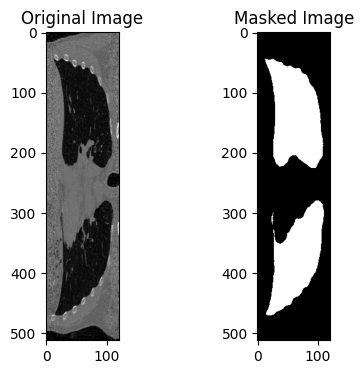

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 4))

axes[0].imshow(img[:,256,:], cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(mask[:,256,:], cmap='gray')
axes[1].set_title('Masked Image')

plt.show()

In [123]:
# Function which normalises the values
def normalizeImageIntensityRange(img):
    """
    This function normalizes the image intensity range from -3500 to 3500 to 0 to 1
    """
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

In [124]:
def readImageVolume(imgPath, normalize=False):
    """
    This function function load the image and then if necessary normalise the image
    """
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img

In [125]:
# Save volume slice to file
def saveSlice(img, fname, path):
    img = np.uint8(img * 255)
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)
    print(f'Slice saved: {fout}')
    
saveSlice(img[:,256,:], 'test', imageSliceOutput)
saveSlice(mask[:,256,:], 'test', maskSliceOutput)

In [126]:
def sliceAndSaveVolumeImage(vol, fname, path):
    """
    This function slices the 3d ct scan and saves 2d slices in the path
    """
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    if SLICE_X:
        cnt += dimx
        print('Slicing X: ')
        for i in range(dimx):
            saveSlice(vol[i,:,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', path)
            
    if SLICE_Y:
        cnt += dimy
        print('Slicing Y: ')
        for i in range(dimy):
            saveSlice(vol[:,i,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', path)
            
    if SLICE_Z:
        cnt += dimz
        print('Slicing Z: ')
        for i in range(dimz):
            saveSlice(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)
    return cnt

In [ ]:
# Load and slice all .nii.gz file images into 2d slices
for index, filename in enumerate(sorted(glob.iglob(imagePathInput+'*.nii.gz'))):
    img = readImageVolume(filename, True)
    numOfSlices = sliceAndSaveVolumeImage(img, 'lung'+str(index), imageSliceOutput)

In [ ]:
# Load and slice all .nii.gz file mask images into 2d slices
for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'*.nii.gz'))):
    img = readImageVolume(filename, False)
    numOfSlices = sliceAndSaveVolumeImage(img, 'lung'+str(index), maskSliceOutput)

### Step 5: Training the Model

- There are different model for training a 3d image segmentation model
- As I dont have enough computational resources, I have used 2D U-Net model for training the model
- (Additionally MedSAM can be used for image segmentation, if more time provided I would have tried)

In [9]:
# Load ML modules
import tensorflow as tf # Tensorflow Library
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Image Data Generator
from tensorflow import keras # Keras Library

##### Data Splitting
- Splitting the data automatically into train and test set using modules such as train_test_split from sklearn might lead to errors
Reason : 
- The data is 3D images and is sliced into 2D images, this is done for every patiend and the images are stored in a folder
- If we split the data using train_test_split, there is a chance that the images of a particular patient might be present in both train and test set
- This will lead to overfitting of the model
- So, in order to avoid, I have splitted the data manually

||Training | Testing| Total |
|--|--|--|--|
|3D CT Scans| 36|9|45|
|3D Masks| 36|9|45|

or

||Training | Testing| Total |
|--|--|--|--|
|2D Sliced CT Scans| 46167|11853|58020|
|2D Masks| 46167|11853|58020|



In [10]:
# Defining Constants for training

SEED = 42 # Seed for reproducibility
BATCH_SIZE_TRAIN = 32 # Batch size for training
BATCH_SIZE_TEST = 32 # Batch size for validation

IMAGE_HEIGHT = 80 # Set the image height for training
IMAGE_WIDTH = 40 # Set the image width for training
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir = './Dataset/2dslices/' # Path to the 2d slices
data_dir_train = os.path.join(data_dir, 'training') # Path to the training data
data_dir_train_image = os.path.join(data_dir_train, 'img')
data_dir_train_mask = os.path.join(data_dir_train, 'mask')

data_dir_test = os.path.join(data_dir, 'test') # Path to the test data
data_dir_test_image = os.path.join(data_dir_test, 'img')
data_dir_test_mask = os.path.join(data_dir_test, 'mask')

NUM_TRAIN = 46167
NUM_TEST = 11853

NUM_OF_EPOCHS = 10

In [11]:
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    """Prepare your dataset so that it can be used during the model training process - train"""
    data_gen_args = dict(rescale=1./255) # just in case normalise the pixel values
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    """Prepare your dataset so that it can be used during the model training process - test"""
    data_gen_args = dict(rescale=1./255) # just in case normalise the pixel values
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

In [2]:
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN) # create the training generator
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST) # create the test generator

Found 46167 images belonging to 1 classes.
Found 46167 images belonging to 1 classes.
Found 11853 images belonging to 1 classes.
Found 11853 images belonging to 1 classes.


In [13]:
def sample_display(display_list):
    "Displays the compared input image, ground truth and prediction."
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [15]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        sample_display([image[0], mask[0]])

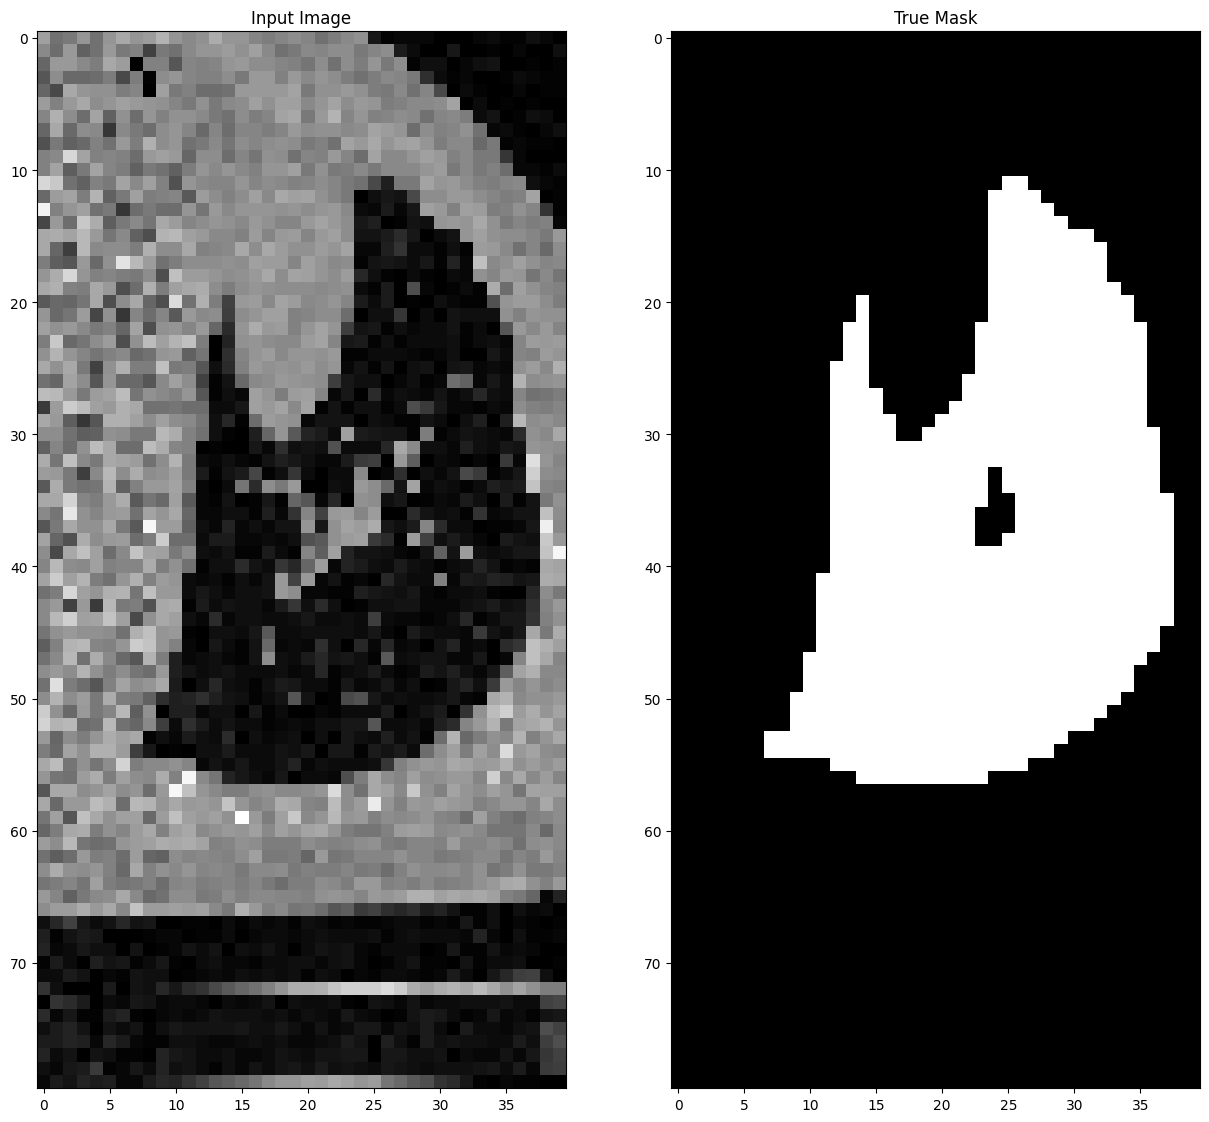

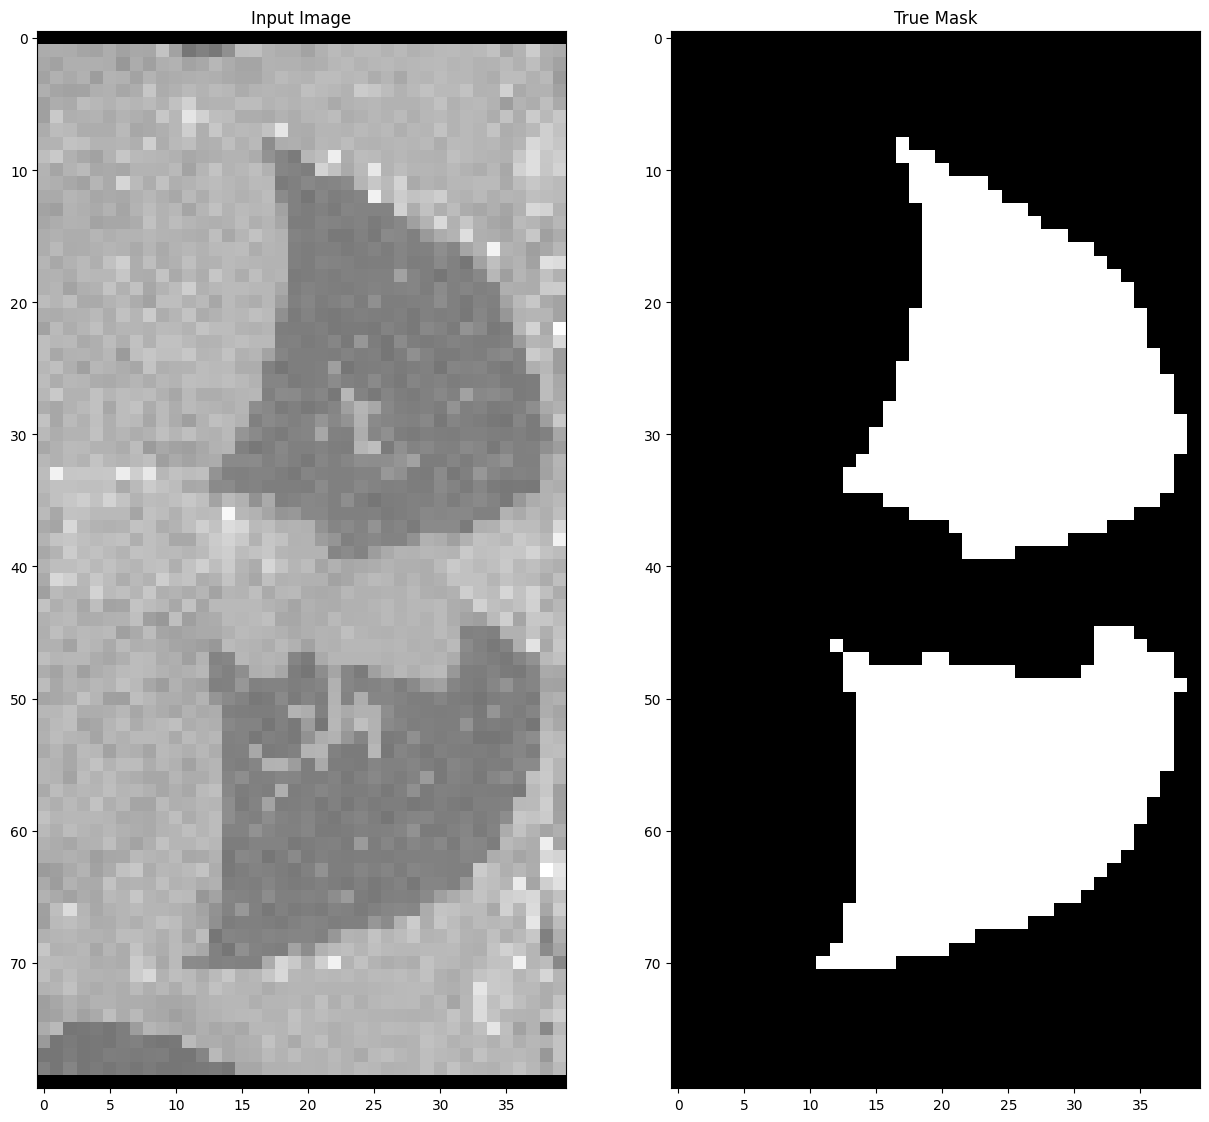

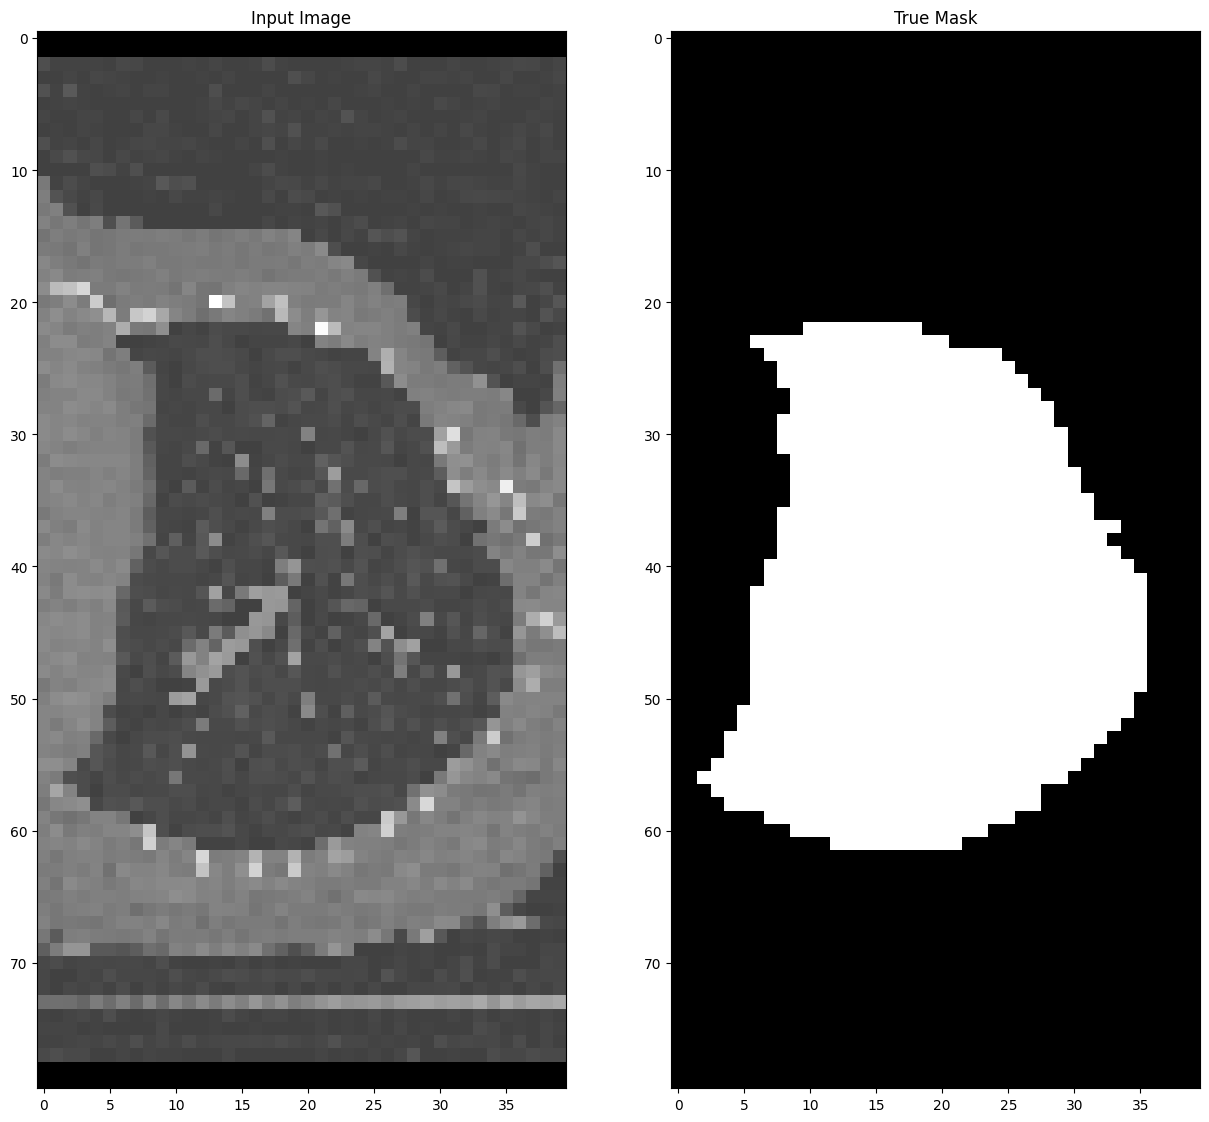

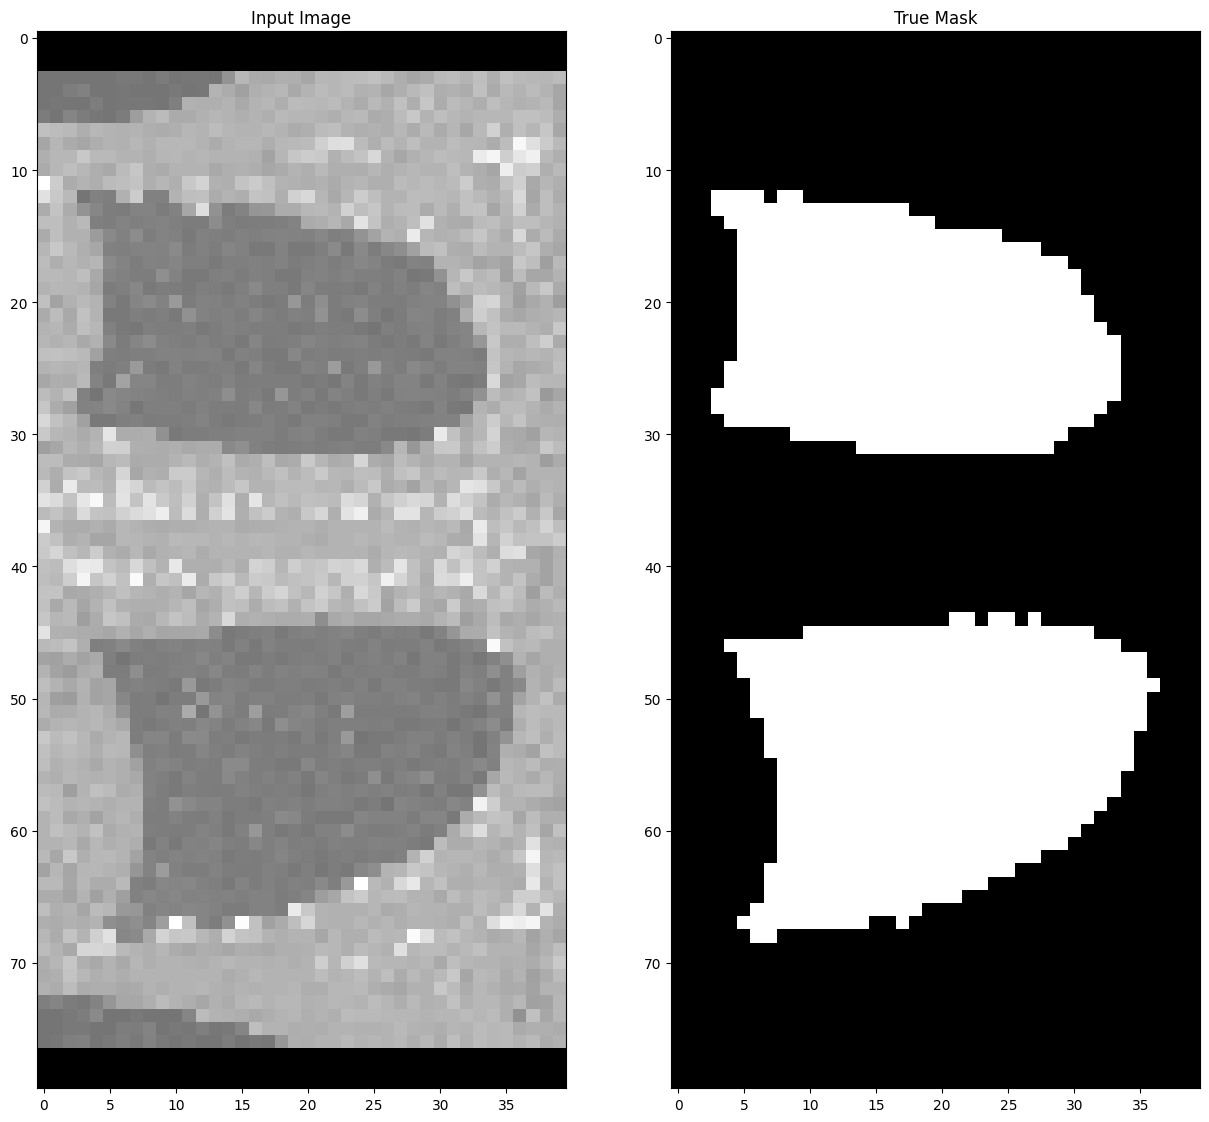

In [16]:
show_dataset(train_generator, 4)

In [18]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #Going down the layers and also storing the skip connections
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # Going up the layers and also applying the skip connections
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}') # Save the model
        

In [20]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN # Number of steps per epoch for trainging
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST # Number of steps per epoch for validation

model = unet(4) # Create the model Unet with 4 levels
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Compile the model

In [21]:
model.summary() # Print the model summary

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 80, 40, 1)]          0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 80, 40, 32)           320       ['input_2[0][0]']             
                                                                                                  
 conv2d_16 (Conv2D)          (None, 80, 40, 32)           9248      ['conv2d_15[0][0]']           
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 40, 20, 32)           0         ['conv2d_16[0][0]']           
 g2D)                                                                                   

In [29]:
model.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                    validation_data=test_generator, 
                    validation_steps=EPOCH_STEP_TEST,
                   epochs=NUM_OF_EPOCHS)

Epoch 1/10
C:\Users\dellg\AppData\Local\Temp\ipykernel_18908\2617483852.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators."
  model.fit_generator(generator=train_generator,"
1152/1152 [==============================] - 656s 569ms/step - loss: 0.0236 - accuracy: 0.9926 - val_loss: 0.0180 - val_accuracy: 0.9938"
Epoch 2/10"
1152/1152 [==============================] - 691s 600ms/step - loss: 0.0207 - accuracy: 0.9937 - val_loss: 0.0184 - val_accuracy: 0.9934"
Epoch 3/10"
1152/1152 [==============================] - 616s 534ms/step - loss: 0.0176 - accuracy: 0.9944 - val_loss: 0.0146 - val_accuracy: 0.9950"
Epoch 4/10"
1152/1152 [==============================] - 618s 536ms/step - loss: 0.0145 - accuracy: 0.9953 - val_loss: 0.0252 - val_accuracy: 0.9917"
Epoch 5/10"
1152/1152 [==============================] - 666s 578ms/step - loss: 0.0130 - accuracy: 0.9956 - val_loss: 0.0275 - val_accuracy: 

In [ ]:
model.save(f"UNET_LungSegmentation_3D_10epochs_GPU_ALL.h5")

In [3]:
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, 1)

Found 11853 images belonging to 1 classes.
Found 11853 images belonging to 1 classes.


In [32]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        sample_display([image[0], mask[0], pred_mask])

1/1 [==============================] - 0s 46ms/step


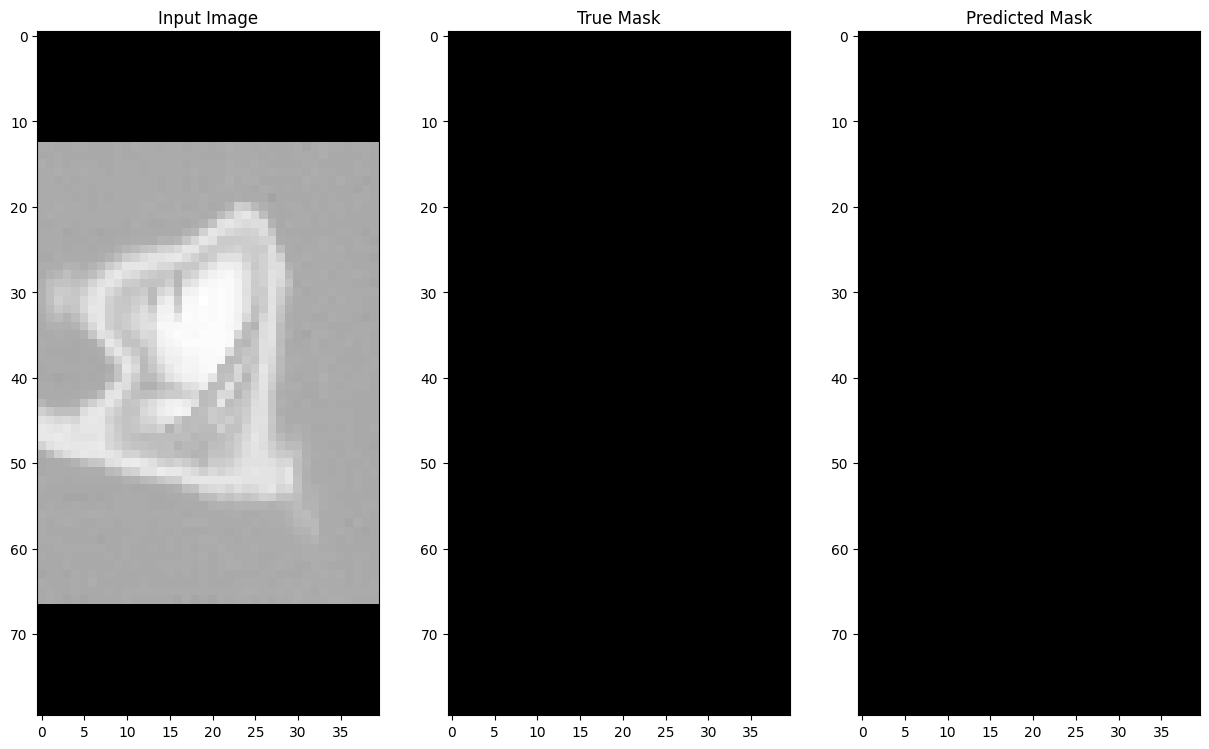

1/1 [==============================] - 0s 40ms/step


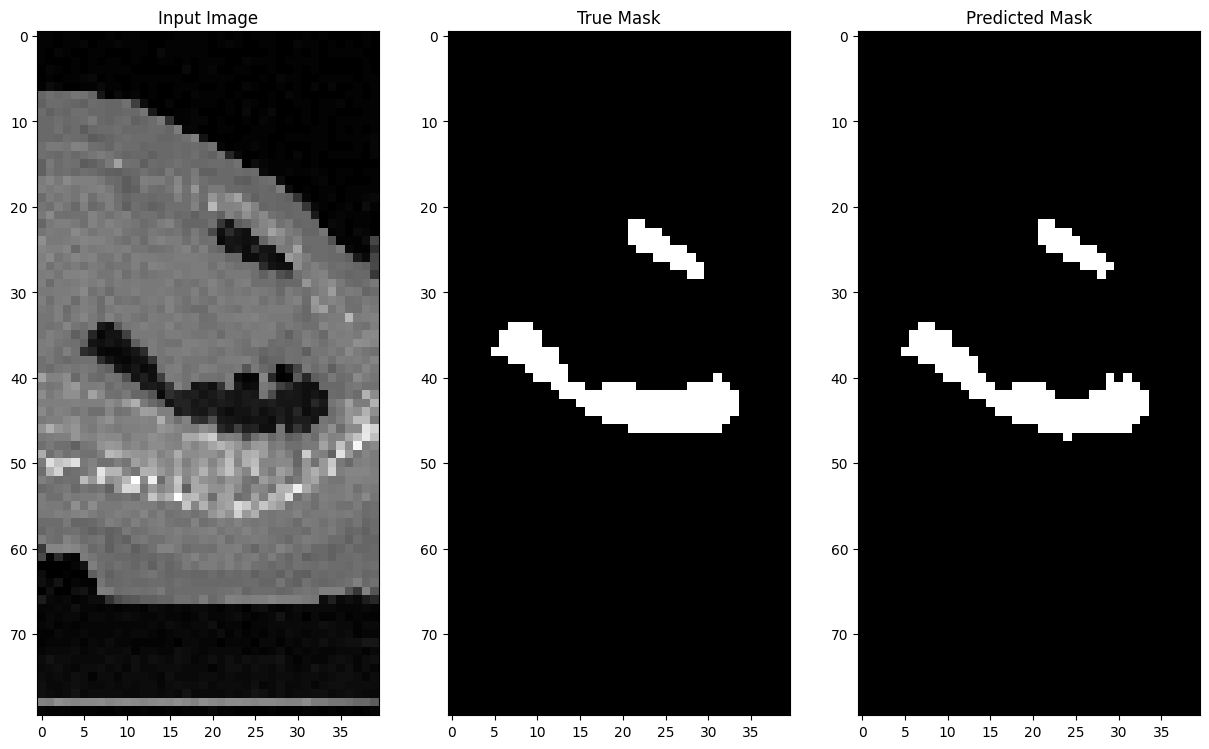

1/1 [==============================] - 0s 44ms/step


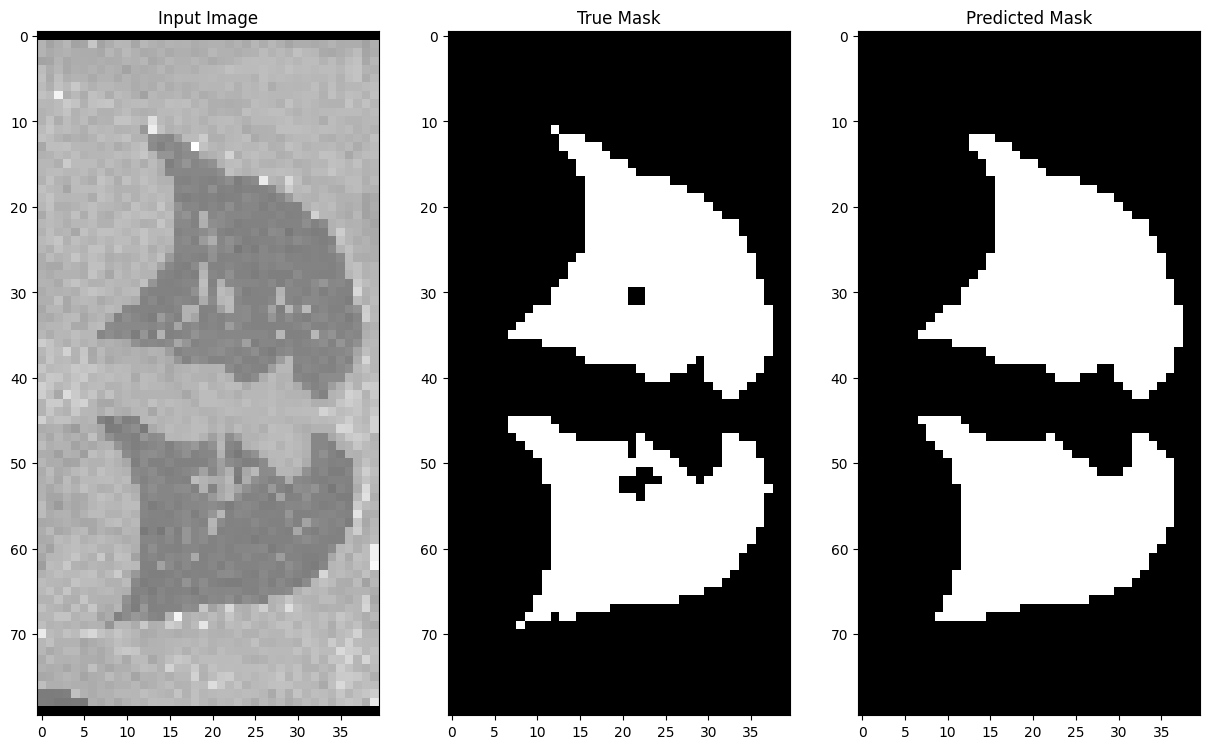

In [36]:
show_prediction(test_generator, 3)

##### Conclusion
- The model has been trained, with accuracy around 98.6%

##### Future Improvements
- The model can be trained without having to create Unet and use MedSAM for training and finetuning which might reduce time and computational resources as that model is already trained on a large dataset
- Create 3d sub volumes and train the model on that, which might give better results

### Step 6: Testing the Model and Image Segmentation

In [93]:
from tensorflow.keras.models import load_model # To load the model
import nibabel as nib # To load the .nii.gz files
import numpy as np # Numpy operations

In [109]:
# Load a sample data
imgTargetNii = nib.load(f"./Dataset/imagesTr/1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827_0000.nii.gz").get_fdata() # load the random 3d image
imgMaskNii = nib.load(f"./Dataset/Modified/1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827.nii.gz").get_fdata() # load the random 3d image

imgTarget = normalizeImageIntensityRange(imgTargetNii) # Normalize the 3d ct scan image
imgMask = imgMaskNii 


In [110]:
# check the shape
imgTarget.shape

(512, 512, 369)

In [111]:
# Load the model
model = load_model('./Models/UNET_LungSegmentation_3D_10epochs_GPU_ALL.h5')

In [112]:
# Scale the image accordingly
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

In [113]:
sliceIndex = 300

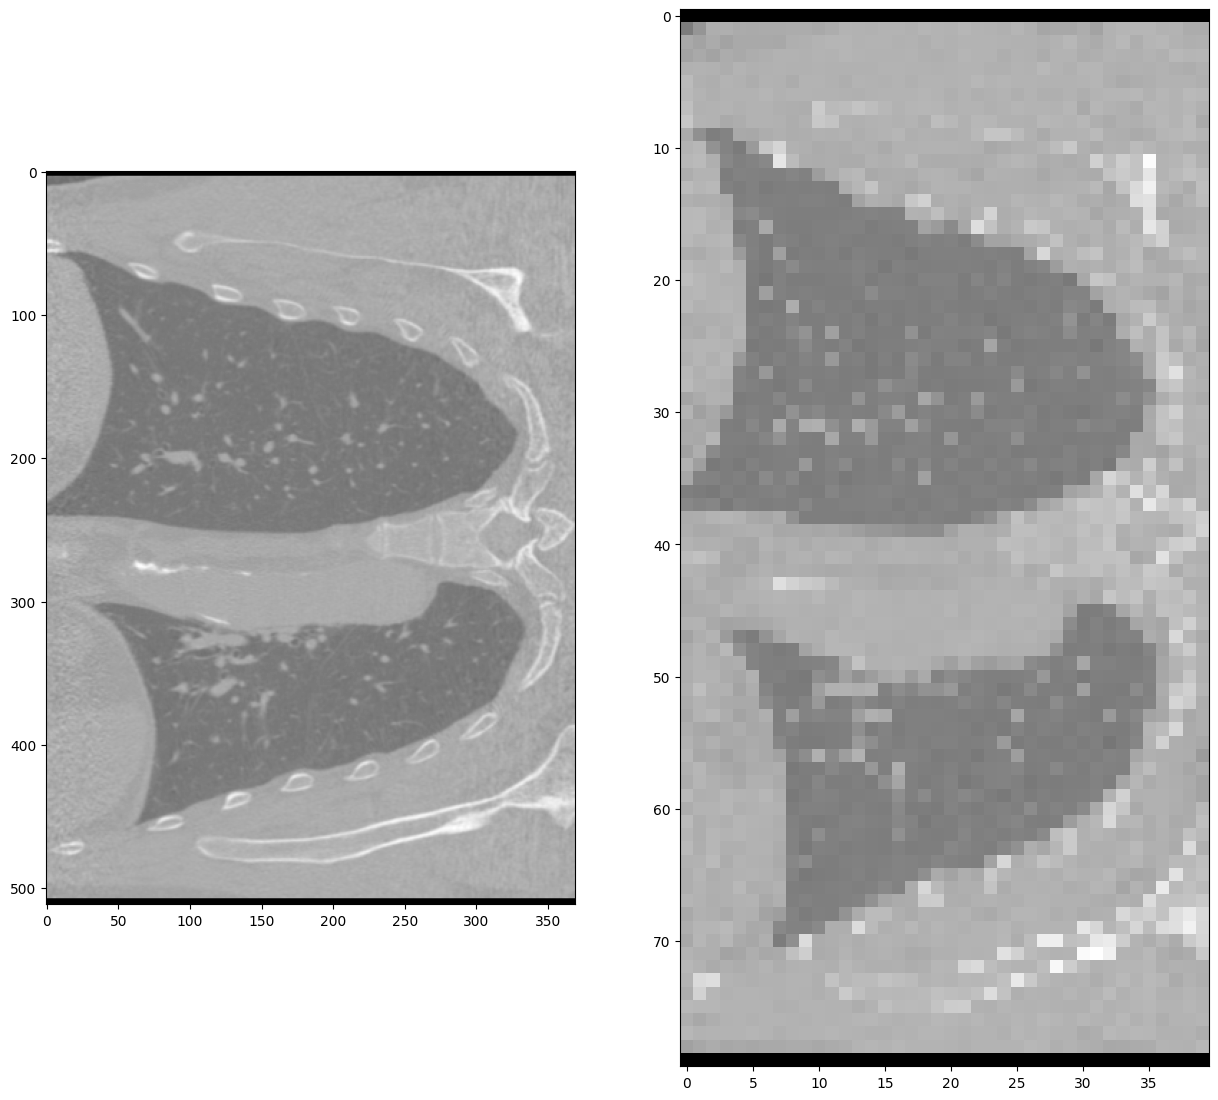

((512, 369), (80, 40))

In [114]:
# Input image slice
plt.figure(figsize=(15,15))
imgSlice = imgTarget[:,sliceIndex,:]
imgDimX, imgDimY = imgSlice.shape
imgSliceScaled = scaleImg(imgSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(imgSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgSliceScaled, cmap='gray')
plt.show()
imgSlice.shape, imgSliceScaled.shape

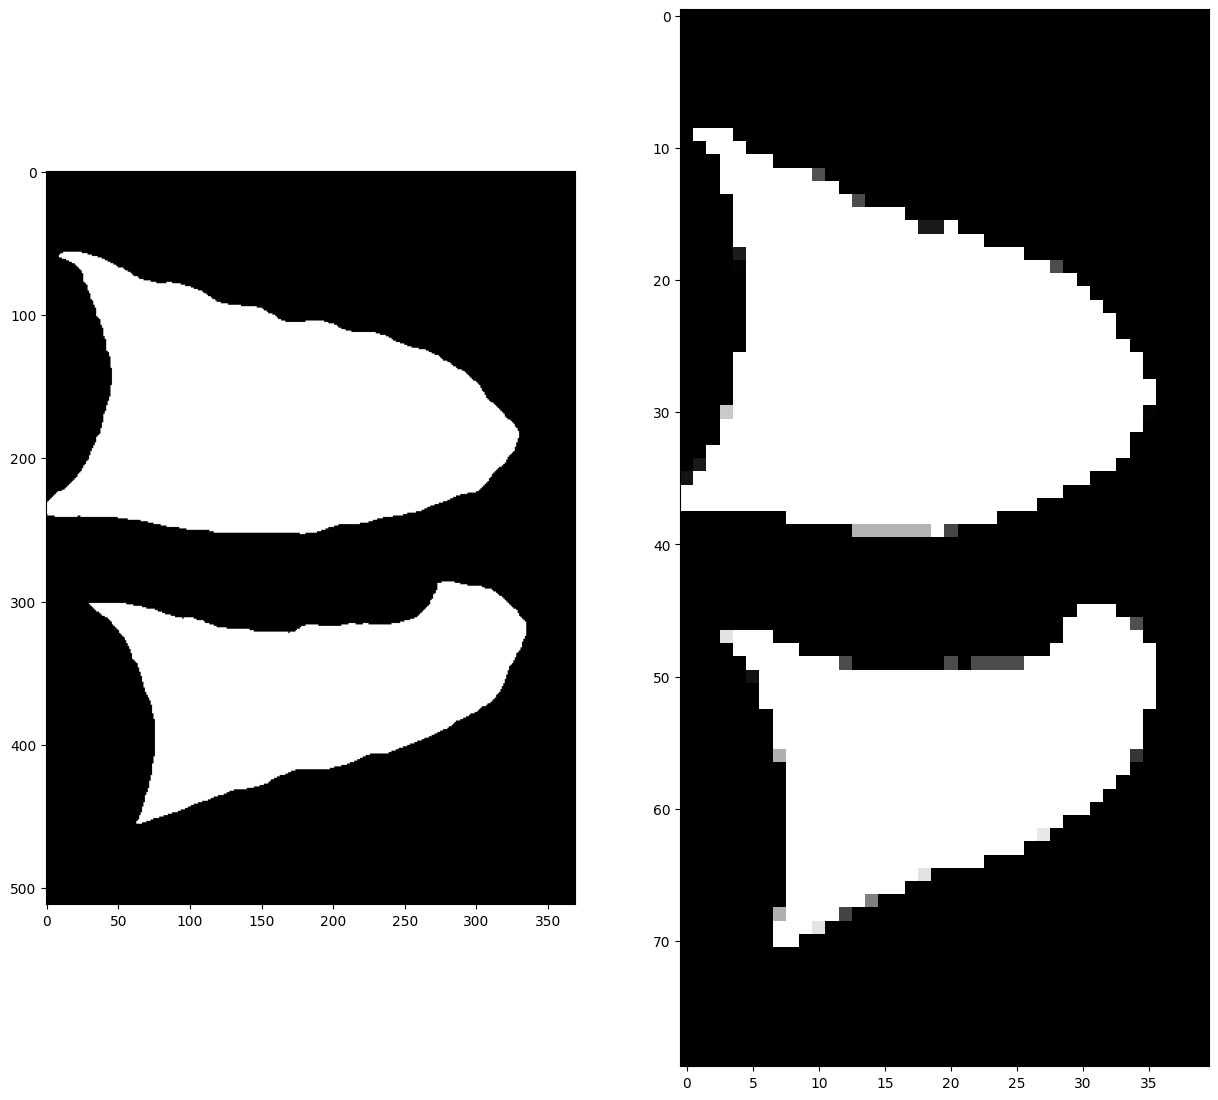

((512, 369), (80, 40))

In [115]:
# Input mask slice
plt.figure(figsize=(15,15))
maskSlice = imgMask[:,sliceIndex,:]
maskSliceScaled = scaleImg(maskSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(maskSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(maskSliceScaled, cmap='gray')
plt.show()
maskSlice.shape, maskSliceScaled.shape

1/1 [==============================] - 0s 423ms/step


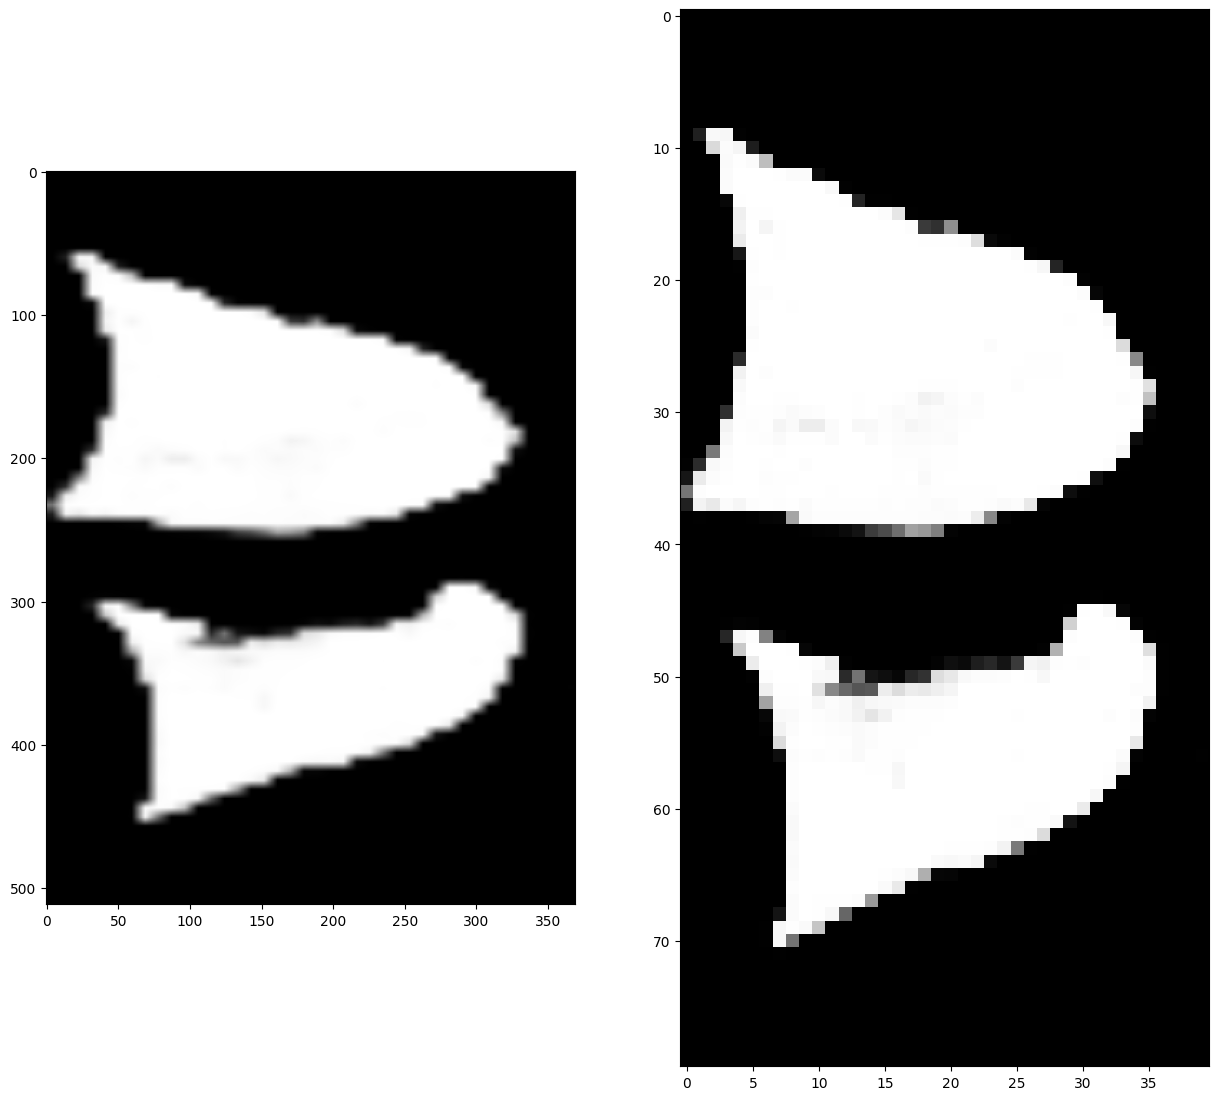

((512, 369), (80, 40))

In [116]:
# Predict from the input image slice, and has given a mask slice
plt.figure(figsize=(15,15))
imageInput = imgSliceScaled[np.newaxis,:,:,np.newaxis]
maskPredict = model.predict(imageInput)[0,:,:,0]
maskPredictScaled = scaleImg(maskPredict, imgDimX, imgDimY)
plt.subplot(1,2,2)
plt.imshow(maskPredict, cmap='gray')
plt.subplot(1,2,1)
plt.imshow(maskPredictScaled, cmap='gray')
plt.show()
maskPredictScaled.shape, maskPredict.shape

In [117]:
def predictVolume(inImg, toBin=True):
    (xMax, yMax, zMax) = inImg.shape
    
    outImgX = np.zeros((xMax, yMax, zMax)) # Create imgx in the shape of inImgx
    outImgY = np.zeros((xMax, yMax, zMax)) # Create imgy in the shape of inImgy
    outImgZ = np.zeros((xMax, yMax, zMax)) # Create imgz in the shape of inImgz
    
    cnt = 0.0
    if SLICE_X:
        cnt += 1.0
        for i in range(xMax):
            img = scaleImg(inImg[i,:,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
    if SLICE_Y:
        cnt += 1.0
        for i in range(yMax):
            img = scaleImg(inImg[:,i,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
    if SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = scaleImg(inImg[:,:,i], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)
            
    outImg = (outImgX + outImgY + outImgZ)/cnt # Concatenate all the sides to form into one
    if(toBin):
        outImg[outImg>0.5] = 1.0 # Appying thresholding if > 0.5 then assign 1
        outImg[outImg<=0.5] = 0.0 # Appying thresholding if <= 0.5 then assign 0
    return outImg

In [119]:
predImg = predictVolume(imgTarget) # get the volume prediction

1/1 [==============================] - 0s 26ms/step


In [120]:
predImg.shape

(512, 512, 369)

In [121]:
# Save the 3d segmented model
a = nib.Nifti1Image(predImg, affine=np.eye(4))
nib.save(a, "segmented-lungs.nii.gz")

##### The below code helps to render the 3d mask image, and predicted image, side by side

- Make sure to save it in file, and then run

In [134]:
import vedo
import os

def display_side_by_side(path1, path2):
    mesh1 = vedo.Volume(path1)
    mesh2 = vedo.Volume(path2)

    vedo.show(mesh1, mesh2, shape=(1, 2))

file1 = "./Dataset/Modified/1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827.nii.gz"
file2 = "segmented-lungs.nii.gz"
display_side_by_side(file1, file2)


#### 3D Mask and 3D predicted Mask comparision

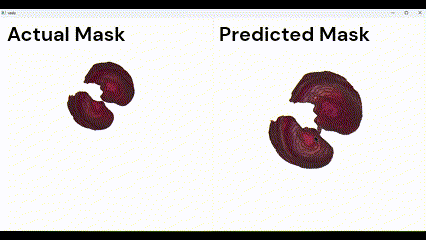

In [132]:
from IPython.display import Image
Image(filename='./Documentation/comparision.gif')
